# Implémentez un modèle de scoring

- **Projet 7 du parcours « Data Scientist » d’OpenClassrooms**
- **Mark Creasey**

## Étape 1 : Préparation du jeu de données et feature engineering


## 1.1 Compréhension du problème

### 1.1.1 Problématique

La société financière, nommée **"Prêt à dépenser"**, propose des crédits à la consommation pour des
personnes ayant peu ou pas du tout d'historique de prêt.

L’entreprise souhaite mettre en œuvre **un outil de “scoring crédit”** pour calculer la qu’un client
rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc
développer **un algorithme de classification** en s’appuyant sur des sources de données variées (données
comportementales, données provenant d'autres institutions financières, etc.).

### 1.1.2 Les données

Voici [les données](https://www.kaggle.com/c/home-credit-default-risk/data) pour réaliser le
dashboard. Pour plus de simplicité, vous pouvez les télécharger à
[cette adresse](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip).

### 1.1.1 Mission

- Sélectionner un kernel Kaggle pour faciliter la préparation des données nécessaires à l’élaboration du modèle de scoring.
- Analyser ce kernel et l’adapter aux besoins de votre mission.

Focalise sur :

1. La construction d'un **modèle de scoring** qui donnera une prédiction sur la probabilité de faillite
   d'un client de façon automatique.
   - élaboration
   - optimisation
   - comprehension (interpretabilité)
2. Construction d'un **dashboard interactif** qui montre avec transparence les décisions d’octroi de
   crédit, à destination des gestionnaires de la relation client permettant d'interpréter les
   prédictions faites par le modèle et d’améliorer la connaissance client des chargés de relation
   client.


## 1.2 Definition de l'environnement

- `local` : Développement local (avec échantillon de 50 Mo de données)
- `colab` : Google Colab
- `kaggle` : Kaggle Kernel


In [1]:
ENV = 'local'

if ENV == 'local':
    # local development
    DATA_FOLDER = '../data/raw'
    OUT_FOLDER = '../data/out'
    IMAGE_FOLDER = '../images/nettoyage'

if ENV == 'colab':
    # Colaboratory - uncomment les 2 lignes suivant pour connecter à votre drive
    # from google.colab import drive
    # drive.mount('/content/drive')
    DATA_FOLDER = '/content/drive/MyDrive/data/OC7'
    OUT_FOLDER = '/content/drive/MyDrive/data/OC7'
    IMAGE_FOLDER = '/content/drive/MyDrive/images/OC7/nettoyage'


## 1.3 Fichiers de données

1. Les données en format CSV (>700Mb compactés) sont à télecharger de ce lien:

- https://www.kaggle.com/c/home-credit-default-risk/data
- Pour plus de simplicité, vous pouvez les télécharger à [cette adresse.](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip)

2.  Placer le fichier compacté (**.zip**) dans le **DATA_FOLDER** défini ci-dessous


### Noms des fichiers de données (identique pour nettoyage et l'analyse exploratoire)

- Le grand fichier zip des données doit être placé dans `DATA_FOLDER` au préalable
- Tous les autres fichiers de données sont téléchargés ou crées pendant le nettoyage, puis enregistrés dans `OUT_FOLDER`


In [2]:
# Données (DATA_FOLDER)
ZIPPED_DATA_FILENAME = f'Projet+Mise+en+prod+-+home-credit-default-risk.zip'
RAW_DATA_FILENAME = 'HomeCredit_columns_description.csv'
SAMPLE_DATA_FILENAME = 'HomeCredit_columns_description.csv'


# Données nettoyés (OUT_FOLDER)
CLEAN_DATA_FILENAME = 'cleaned_data_scoring.csv'
CLEAN_DATA_SAMPLE = 'cleaned_data_sample.csv'  # 100,000 registres
SAMPLE_SIZE = 100000


## 1.4 Requirements: Bibliothèques utilisées dans ce notebook

Ce notebook marche a été testé en developpement local, sur Google Colab et Kaggle

```txt
# copy dans un fichier requirements.txt, puis
# !pip install -r requirements.txt
python>=3.7,<=3.9
numpy>=1.19.5,<=1.21.2
pandas>=1.1.5,<=1.3.4
matplotlib>=3.2.2,<=3.5.0
seaborn==0.11.2
scikit-learn>=1.0.1
```


In [3]:
# Decommentarise la ligne suivant si vous ne voulez pas changer vos versions existants
# !pip install numpy pandas matplotlib seaborn scipy sklearn missingno requests


## 1.5 Import dependencies


### 1.5.1 Import des bibliothèques utilisées par ce notebook


In [4]:
# suppress furture warnings de pandas 1.3.0
from contextlib import contextmanager
import time
import gc
import sklearn
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import platform
warnings.simplefilter(action='ignore', category=FutureWarning)


### 1.5.2 Liste des versions des bibliothèques utilisées


In [5]:
print(f'python version = {platform.python_version()}')
print('versions des bibliothèques utilisées:')
print('; '.join(f'{m.__name__}=={m.__version__}' for m in globals(
).values() if getattr(m, '__version__', None)))


python version = 3.7.0
versions des bibliothèques utilisées:
sklearn==1.0.2; seaborn==0.11.2; pandas==1.1.5; numpy==1.21.5; platform==1.0.8


### 1.5.3 Configuration défauts d'affichage


In [6]:
pd.set_option('display.max_columns', 200)  # pour afficher toutes les colonnes
pd.set_option('display.max_rows', 10)  # pour afficher max 10 lignes
pd.set_option('display.max_colwidth', 100)

%matplotlib inline
sns.set_theme(style="white", context="notebook")
sns.set_color_codes("pastel")
sns.set_palette("tab20")


### Bibliothèque personelle

On utilise un nom non standard


In [7]:
import outils
from outils.vis import to_png
from outils.timed import timer


### Configuration personelle


In [8]:

# Enregistre parametres globals dans outils
outils.vis.set_option('IMAGE_FOLDER', IMAGE_FOLDER)
outils.vis.set_option('SAVE_IMAGES', True)

if ENV != 'kaggle':
    outils.io.os_make_dir(DATA_FOLDER)
    outils.io.os_make_dir(OUT_FOLDER)

outils.io.os_make_dir(IMAGE_FOLDER)


# 2. Importation des données <a name="importation"></a>


## 2.1 Configuration de l'environnement de travail

### 2.1.1 Installation des bibliothèques nécessaires pour manipuler les données

Pour plusieurs notebooks dans un dossier, enregistre une liste des bibliothèques dans un fichier `requirements.txt`


In [9]:
outils.io.install_libraries({'numpy', 'pandas', 'matplotlib',
                                'seaborn', 'requests', 'missingno'})


required modules: ['pandas', 'seaborn', 'missingno', 'matplotlib', 'requests', 'numpy']
missing modules: []


## 2.2 Configuration de l'importation des données

### 2.2.1 Choix de fichier à analyser


In [10]:
DATA_FILENAME = SAMPLE_DATA_FILENAME if ENV == 'local' else RAW_DATA_FILENAME
RAW_DATA = outils.io.os_path_join(DATA_FOLDER, DATA_FILENAME)
DATA_ZIPPED = outils.io.os_path_join(DATA_FOLDER, ZIPPED_DATA_FILENAME)
print(f'data file: {RAW_DATA}')


data file: ../data/raw/HomeCredit_columns_description.csv


In [11]:
def unzip_data_si_besoin(env=ENV):
    """procedure pour unzip sur Google Drive via Google Colab"""
    if os.path.exists(RAW_DATA):
        print(f'data CSV file exists ({RAW_DATA})')
    else:
        print(f'data CSV file does not exist ({RAW_DATA})')
        if env == 'colab' and os.path.exists(DATA_ZIPPED):
            # uncomment les 3 lignes suivants
            print(f'unzipping {DATA_ZIPPED}')
            !unzip {DATA_ZIPPED} - d {DATA_FOLDER}
            print(f'{DATA_ZIPPED} has been unzipped')
            if os.path.exists(RAW_DATA):
                print(f'data CSV file now exists ({RAW_DATA})')
        else:
            print(f'zipped data does not exist ({DATA_ZIPPED})')


unzip_data_si_besoin(ENV)


data CSV file exists (../data/raw/HomeCredit_columns_description.csv)


### 2.2.2 Information sur le fichier (taille, type, nb. registres, champs)


In [12]:

for filename in os.listdir(DATA_FOLDER):
    if filename.lower().endswith('csv'):
        filepath = f'{DATA_FOLDER}/{filename}'
        print(f'file : {filename} : size={outils.io.get_filesize(filepath)}')


file : application_test.csv : size=25.34 Mo
file : application_train.csv : size=158.44 Mo
file : bureau.csv : size=162.14 Mo
file : bureau_balance.csv : size=358.19 Mo
file : credit_card_balance.csv : size=404.91 Mo
file : HomeCredit_columns_description.csv : size=36.51 ko
file : installments_payments.csv : size=689.62 Mo
file : POS_CASH_balance.csv : size=374.51 Mo
file : previous_application.csv : size=386.21 Mo
file : sample_submission.csv : size=523.63 ko


## 2.3 Data schema

Le schema et description des données est fourni sur le lien:

- https://www.kaggle.com/competitions/home-credit-default-risk/data

<p><img title="" alt="Data" src="img/home_credit.png"></p>
<em>Original source : https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png<em>


### 2.3.1 Description des champs

- details sur <https://www.kaggle.com/competitions/home-credit-default-risk/data>


In [13]:
def field_descriptions(data_dir=DATA_FOLDER, num_rows=1000):
    df = pd.read_csv(f'{data_dir}/HomeCredit_columns_description.csv',
                     nrows=num_rows, encoding='unicode_escape')
    return df


field_descriptions().head()


,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment difficulties: he/she had late payment more than X days ...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN


## 2.4 Join des tables

Comme indiqué dans la cahier de charges, on sélectionne un kernel Kaggle pour faciliter la préparation des données nécessaires à l’élaboration du modèle de scoring.

Les procédures de fusion des tables ci-dessous sont basés sur le pipeline de feature engineering présenté dans :

- <https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script>


### One-hot encoding for categorical columns


In [14]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [
        col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns,
                        dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns


### Preprocess application_train.csv

#### [application\_{train|test}.csv](https://www.kaggle.com/competitions/home-credit-default-risk/data)

This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).

Static data for all applications. One row represents one loan in our data sample.


In [15]:
def application_train(data_dir='data', num_rows=None, nan_as_category=False):
    # Read data
    print(f'application_train, data_dir = {data_dir}')
    df = pd.read_csv(f'{data_dir}/application_train.csv', nrows=num_rows)
    print(f'Train samples: {len(df)}')

    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']

    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    gc.collect()
    return df


### Preprocess bureau.csv and bureau_balance.csv

#### bureau.csv

All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).

For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

#### bureau_balance.csv

Monthly balances of previous credits in Credit Bureau.

This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has
`(#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows`.


In [16]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(data_dir='data', num_rows=None, nan_as_category=True):
    bureau = pd.read_csv(f'{data_dir}/bureau.csv', nrows=num_rows)
    bb = pd.read_csv(f'{data_dir}/bureau_balance.csv', nrows=num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)

    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper()
                              for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace=True)
    del bb, bb_agg
    gc.collect()

    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat:
        cat_aggregations[cat] = ['mean']
    for cat in bb_cat:
        cat_aggregations[cat + "_MEAN"] = ['mean']

    bureau_agg = bureau.groupby('SK_ID_CURR').agg(
        {**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(
        ['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(
        ['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(
        ['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg


### Preprocess previous_applications.csv

#### previous_application.csv

All previous applications for Home Credit loans of clients who have loans in our sample.

There is one row for each previous application related to loans in our data sample.


In [17]:

def previous_applications(data_dir='data', num_rows=None, nan_as_category=True):
    prev = pd.read_csv(f'{data_dir}/previous_application.csv', nrows=num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category=True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']

    prev_agg = prev.groupby('SK_ID_CURR').agg(
        {**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(
        ['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(
        ['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(
        ['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg


### Preprocess POS_CASH_balance.csv

#### POS_CASH_balance.csv

Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.

This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has `(#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows`.


In [18]:

def pos_cash(data_dir='data', num_rows=None, nan_as_category=True):
    pos = pd.read_csv(f'{data_dir}/POS_CASH_balance.csv', nrows=num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category=True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']

    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(
        ['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg


### Preprocess installments_payments.csv

#### installments_payments.csv

Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.

There is a) one row for every payment that was made plus b) one row each for missed payment.

One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.


In [19]:

def installments_payments(data_dir='data', num_rows=None, nan_as_category=True):
    ins = pd.read_csv(f'{data_dir}/installments_payments.csv', nrows=num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category=True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(
        ['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg


### Preprocess credit_card_balance.csv

#### credit_card_balance.csv

Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.

This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has `(#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows`.


In [20]:

def credit_card_balance(data_dir='data', num_rows=None, nan_as_category=True):
    cc = pd.read_csv(f'{data_dir}/credit_card_balance.csv', nrows=num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category=True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis=1, inplace=True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper()
                              for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg


## 2.5 Preprocessing pipeline


In [21]:
from outils import preprocess

def preprocess_pipeline(data_dir=DATA_FOLDER, num_rows=None, debug=False):
    # num_rows = 10000 if debug else None
    print(f'data_dir={data_dir}')
    df = application_train(data_dir, num_rows)
    start = time.time()
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(data_dir, num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(data_dir, num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(data_dir, num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(data_dir, num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(data_dir, num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()

    with timer("Reduce field sizes"):
        df=preprocess.reduce_memory(df)
    
    time_taken = time.time() - start
    print(f'preprocessing completed in {time_taken:.0f} s')
    return df


### Test pre-processing pipeline


In [22]:
df_data = preprocess_pipeline(data_dir=DATA_FOLDER, num_rows=None, debug=False)


data_dir=../data/raw
application_train, data_dir = ../data/raw
Train samples: 307511
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 33s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 34s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 18s
Installments payments df shape: (339587, 26)
Process installments payments - done in 41s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 21s
Initial df memory usage is 1599.16 MB for 797 columns
Final memory usage is: 567.75 MB - decreased by 64.5%
Reduce field sizes - done in 9s
preprocessing completed in 156 s


In [23]:
savepath = f'{OUT_FOLDER}/{CLEAN_DATA_FILENAME}'
with timer(f'Save to {savepath}'):
    df_data.to_csv(savepath, encoding='UTF-8', sep='\t', index=False)


Save to ../data/out/cleaned_data_scoring.csv - done in 272s


In [24]:
if len(df_data) > SAMPLE_SIZE:
    outpath = f'{OUT_FOLDER}/{CLEAN_DATA_SAMPLE}'
    with timer(f'Save sample (nb = {SAMPLE_SIZE}) to {outpath}'):
        df_data.sample(SAMPLE_SIZE).to_csv(
            outpath, encoding='UTF-8', sep='\t', index=False)


Save sample (nb = 100000) to ../data/out/cleaned_data_sample.csv - done in 81s


### Taille des fichiers préprocessés


In [25]:
for filename in [CLEAN_DATA_FILENAME, CLEAN_DATA_SAMPLE]:
    filepath = f'{OUT_FOLDER}/{filename}'
    print(f'file : {filename} : size={outils.io.get_filesize(filepath)}')


file : cleaned_data_scoring.csv : size=919.9 Mo
file : cleaned_data_sample.csv : size=299.01 Mo


# 3. Vérification des données

Nous avons utilisés un preprocessing qui a donné un bon score sur LightGBM


In [26]:
print(df_data.shape)


(307507, 797)


## 3.1 Colonnes avec des valeurs NaN

Le framework [LightGBM](https://lightgbm.readthedocs.io/en/latest/) accepte les valeurs NaN, et même les utilise pour aider la classification

Autres classificateurs ne peuvent pas traité des valeurs NaNs, comme:
- [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) 
- [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
- [Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB)

On regarde le nombre de valeurs NaN

In [27]:
def list_nan_columns(df):
    nan_cols = [i for i in df.columns if df[i].isnull().any()]
    return nan_cols


nan_colonnes = list_nan_columns(df_data)
print(f'Nombre de colonnes avec NaN values : {len(nan_colonnes)}')

Nombre de colonnes avec NaN values : 616


Presque toutes les colonnes contient les NaNs

On regarde le pourcentage remplissage



In [28]:
from outils import stats
df_remplissage= stats.decrire_dataframe(df_data)
df_remplissage.head()

307507 registres


,% manquantes,unique,dtype,min,max,std
column,,,,,,
SK_ID_CURR,0.0,307507,int32,100002.0,456255.0,102790.132982
TARGET,0.0,2,int8,0.0,1.0,0.272420
CODE_GENDER,0.0,2,int8,0.0,1.0,0.474263
FLAG_OWN_CAR,0.0,2,int8,0.0,1.0,0.473745
FLAG_OWN_REALTY,0.0,2,int8,0.0,1.0,0.460970


In [29]:
df_remplissage['% manquantes'].describe()

count    797.000000
mean      25.927327
std       30.438497
min        0.000000
25%        5.160208
50%        5.667838
75%       67.386108
max       85.311554
Name: % manquantes, dtype: float64

- Plus que le moitié des colonnes ont moins que 6% des valeurs manquantes
- Un quart des colonnes ont plus que 67% des données manquantes

Si on décide qu'il faut un minimum de 70% de remplissage, combien de colonnes sont exclus?

In [30]:
def proportion_cols_unfilled(df,col='% manquantes',threshold=30):
    nb_cols= len(df)
    cols_unfilled= (df[col]>threshold).sum()
    proportion = cols_unfilled/nb_cols
    return proportion
prop_cols=proportion_cols_unfilled(df_remplissage)
print(f'% colonnes avec plus de 30% manquantes = {(prop_cols*100):.0f} %')

% colonnes avec plus de 30% manquantes = 32 %


On visualise sur des graphiques

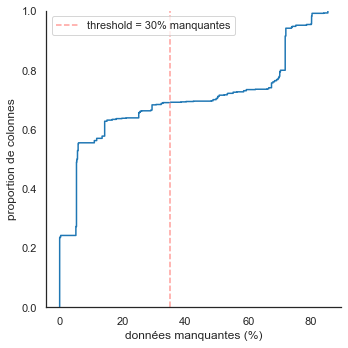

In [31]:
sns.displot(data=df_remplissage, x='% manquantes', kind= 'ecdf')
plt.axvline(35, label='threshold = 30% manquantes', ls='--',c='r')
plt.xlabel('données manquantes (%)')
plt.ylabel('proportion de colonnes')
plt.legend()